In [1]:
import warnings

warnings.filterwarnings("ignore")

import os
import glob
import json
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties
from adjustText import adjust_text
import seaborn as sns

font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc'
font = FontProperties(fname=font_path)

## Data Statistics

In [2]:
def load_cases(filepath, language):
    data = []
    failed_lines = []
    with open(filepath, "r", encoding="utf-8") as f:
        for line_number, line in enumerate(f, 1):
            line = line.strip()
            if language == 'zh':
                parts = line.replace(" ", "").split("\t")
                if len(parts) != 3 or parts[2] not in ["T", "F", "N"]:
                    failed_lines.append((line_number, line))
                    continue
                guess, title, label = parts
            else:  # English
                parts = line.strip().split("\t|\t")
                if len(parts) != 3 or parts[2] not in ["Correct", "Incorrect", "Unknown"]:
                    failed_lines.append((line_number, line))
                    continue
                guess, title, label = parts
            data.append({'guess': guess, 'title': title, 'label': label})
    df = pd.DataFrame(data)

    return df

In [3]:
# Load data
en_cases = load_cases("./data/en/cases.list", "en")
zh_cases = load_cases("./data/zh/cases.list", "zh")

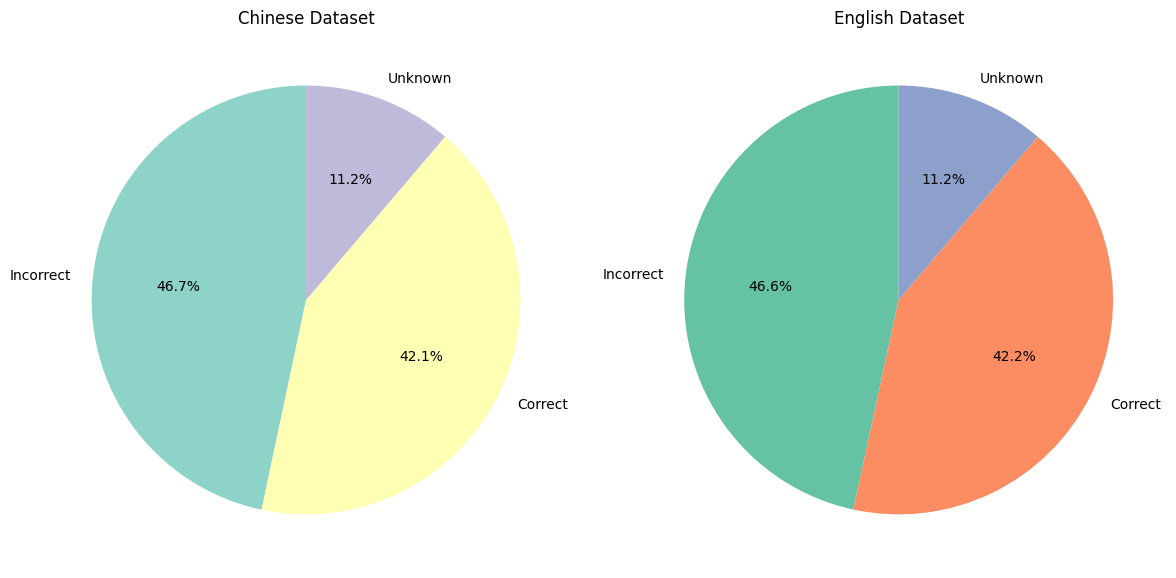

In [4]:
 # Plot distribution of labels for both languages using pie charts
en_counts = en_cases['label'].value_counts()
zh_counts = zh_cases['label'].value_counts()

colors_en = sns.color_palette('Set2', len(en_counts))
colors_zh = sns.color_palette('Set3', len(zh_counts))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

zh_counts.index = ['Incorrect', 'Correct', 'Unknown']
ax[0].pie(zh_counts, labels=zh_counts.index, autopct='%1.1f%%', startangle=90, colors=colors_zh)
ax[0].set_title("Chinese Dataset")

ax[1].pie(en_counts, labels=en_counts.index, autopct='%1.1f%%', startangle=90, colors=colors_en)
ax[1].set_title("English Dataset")

plt.tight_layout()
plt.show()

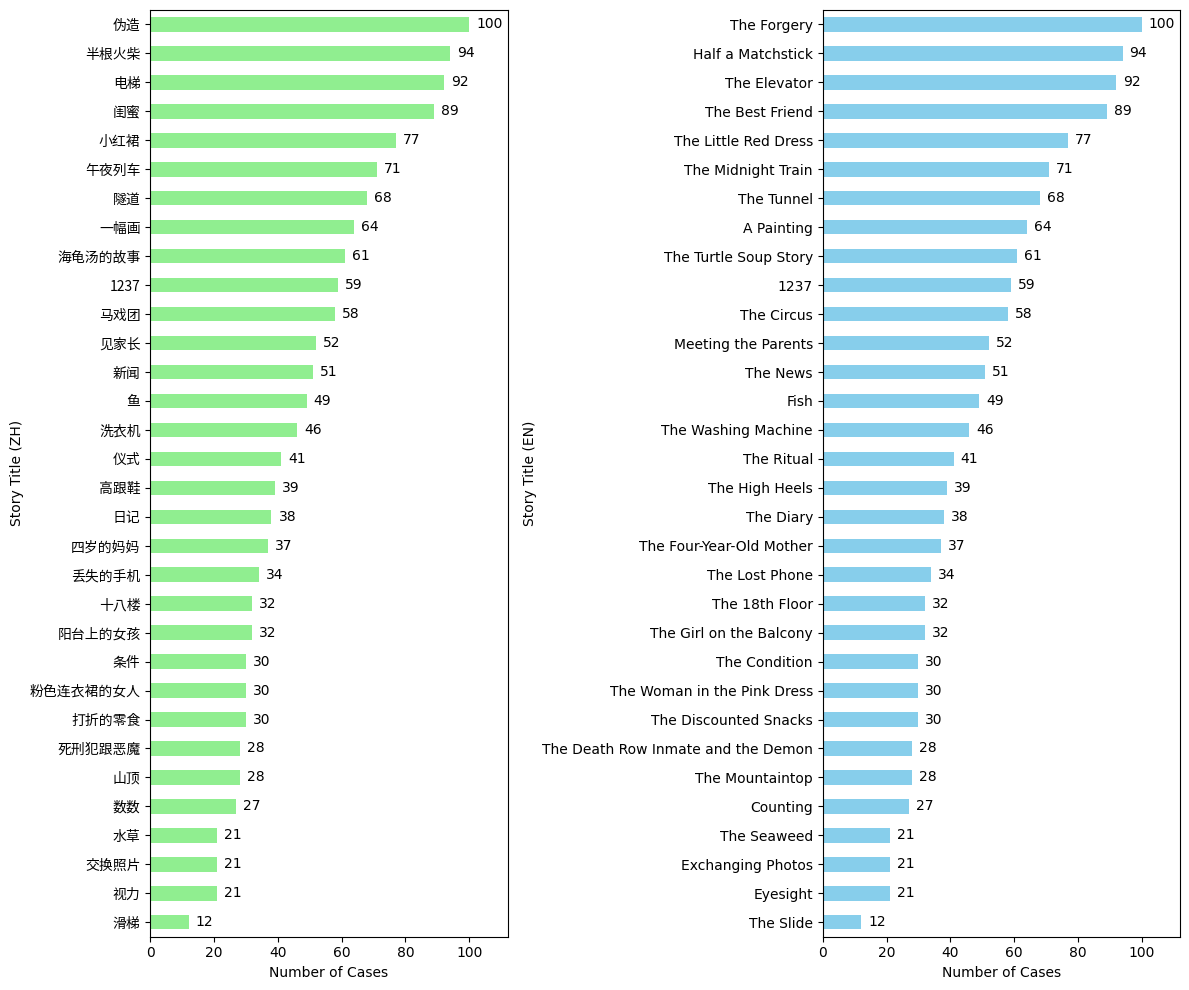

In [5]:
# Plot distribution of titles for both languages using horizontal bar charts
en_titles = en_cases['title'].value_counts().sort_values(ascending=True)
zh_titles = zh_cases['title'].value_counts().sort_values(ascending=True)


fig, ax = plt.subplots(1, 2, figsize=(12, 10))

zh_titles.plot(kind='barh', ax=ax[0], color='lightgreen')
ax[0].set_ylabel('Story Title (ZH)')
ax[0].set_xlabel('Number of Cases')

en_titles.plot(kind='barh', ax=ax[1], color='skyblue')
ax[1].set_ylabel('Story Title (EN)')
ax[1].set_xlabel('Number of Cases')

ax[0].set_xlim(0, zh_titles.max() * 1.12)
ax[1].set_xlim(0, en_titles.max() * 1.12)

# Add text annotations
for i, v in enumerate(zh_titles.values):
    ax[0].annotate(f'{v}', xy=(v, i), xytext=(5, 0), textcoords='offset points', ha='left', va='center')
for i, v in enumerate(en_titles.values):
    ax[1].annotate(f'{v}', xy=(v, i), xytext=(5, 0), textcoords='offset points', ha='left', va='center')

for label in ax[0].get_yticklabels():
    label.set_fontproperties(font)

plt.tight_layout()
plt.show()

## Results Analysis

### Logs

In [6]:
def load_logs(model_name, language, shot_type):
    logs = []
    filename_prefix = f"all_cases_{model_name}_{language}_shot{shot_type}"
    
    if language == "zh":
        log_folder = f"./logs/zh_with_{shot_type}shots"
    else:
        log_folder = f"./logs/en_with_{shot_type}shots"

    # Find all log files for the model
    log_files = glob.glob(os.path.join(log_folder, f"{filename_prefix}_*.json"))

    if not log_files:
        print(f"No logs found for model: {model_name}")
        return None

    for log_file in sorted(log_files):
        with open(log_file, "r", encoding="utf-8") as f:
            data = json.load(f)
            logs.append(data['overall'])

    return logs

In [7]:
def plot_accuracy_trend(zh_accuracies, en_accuracies, model_name, smoothing_window=5):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    zh_accuracies_smoothed = np.convolve(zh_accuracies, np.ones(smoothing_window)/smoothing_window, mode='valid')
    en_accuracies_smoothed = np.convolve(en_accuracies, np.ones(smoothing_window)/smoothing_window, mode='valid')

    zh_std = [np.std(zh_accuracies[i:i + smoothing_window]) for i in range(len(zh_accuracies) - smoothing_window + 1)]
    en_std = [np.std(en_accuracies[i:i + smoothing_window]) for i in range(len(en_accuracies) - smoothing_window + 1)]

    min_acc = min(min(zh_accuracies), min(en_accuracies))
    max_acc = max(max(zh_accuracies), max(en_accuracies))
    y_min, y_max = min_acc - 0.1, max_acc + 0.1

    ax1.plot(range(1, len(zh_accuracies) + 1), zh_accuracies, marker='o', linestyle='-', color='#1f77b4', label='Original Accuracy', alpha=0.7)
    ax1.plot(range(smoothing_window, len(zh_accuracies) + 1), zh_accuracies_smoothed, marker='o', linestyle='-', color='#ff7f0e', label=f'Smoothed (window={smoothing_window})')
    ax1.fill_between(range(smoothing_window, len(zh_accuracies) + 1), 
                     zh_accuracies_smoothed - zh_std, 
                     zh_accuracies_smoothed + zh_std, 
                     color='gray', alpha=0.2, label='Standard Deviation Range')
    ax1.set_title(f'{model_name} - Chinese Data (zh)', fontsize=16)
    ax1.set_xlabel('Log Index', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.set_ylim([y_min, y_max])
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend(loc='best')

    ax2.plot(range(1, len(en_accuracies) + 1), en_accuracies, marker='o', linestyle='-', color='#1f77b4', label='Original Accuracy', alpha=0.7)
    ax2.plot(range(smoothing_window, len(en_accuracies) + 1), en_accuracies_smoothed, marker='o', linestyle='-', color='#ff7f0e', label=f'Smoothed (window={smoothing_window})')
    ax2.fill_between(range(smoothing_window, len(en_accuracies) + 1), 
                     en_accuracies_smoothed - en_std, 
                     en_accuracies_smoothed + en_std, 
                     color='gray', alpha=0.2, label='Standard Deviation Range')
    ax2.set_title(f'{model_name} - English Data (en)', fontsize=16)
    ax2.set_xlabel('Log Index', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_ylim([y_min, y_max])
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend(loc='best')

    plt.tight_layout()
    plt.show()

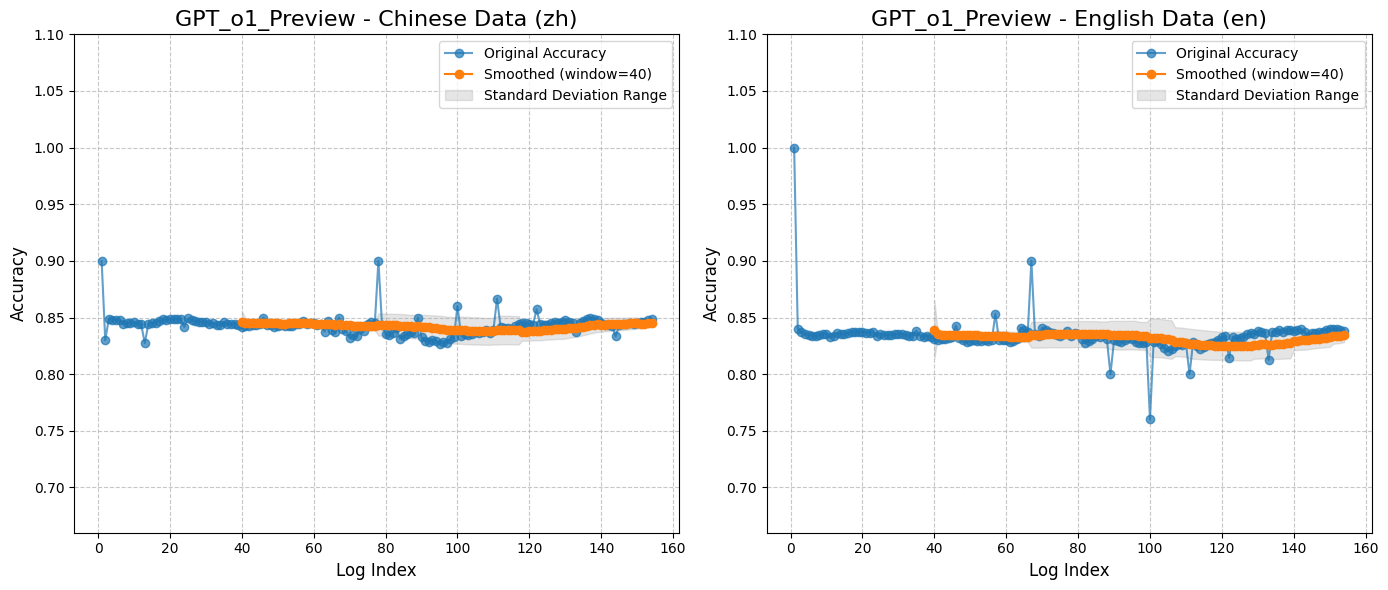

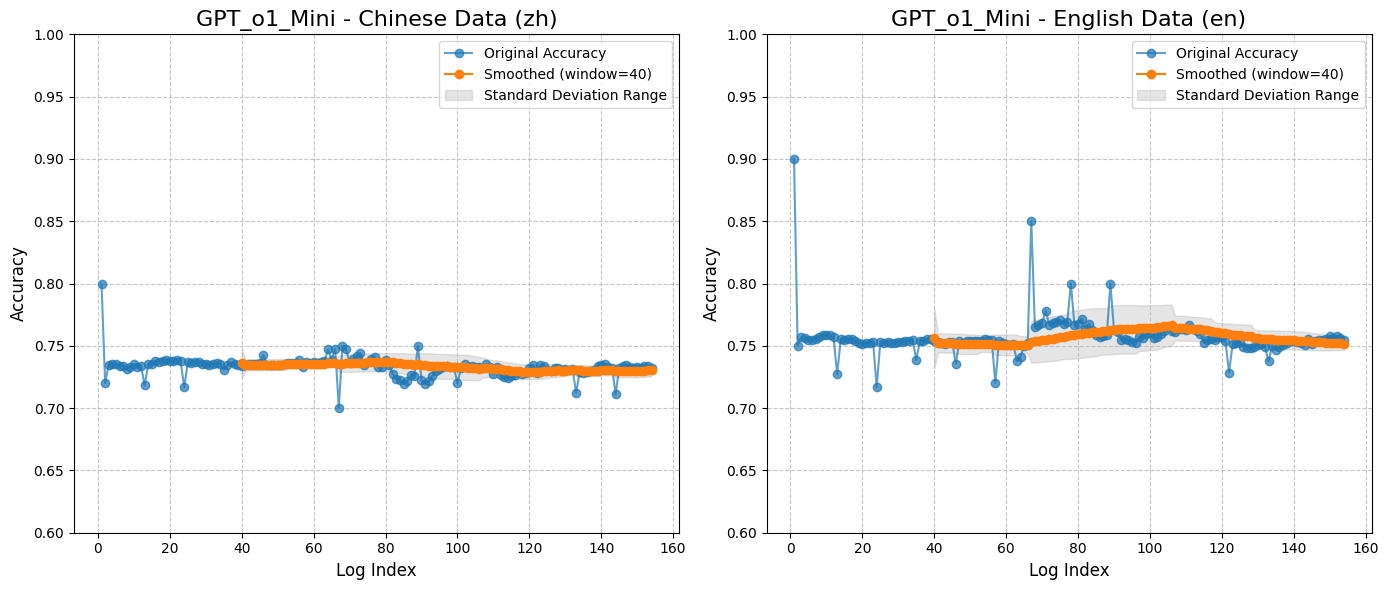

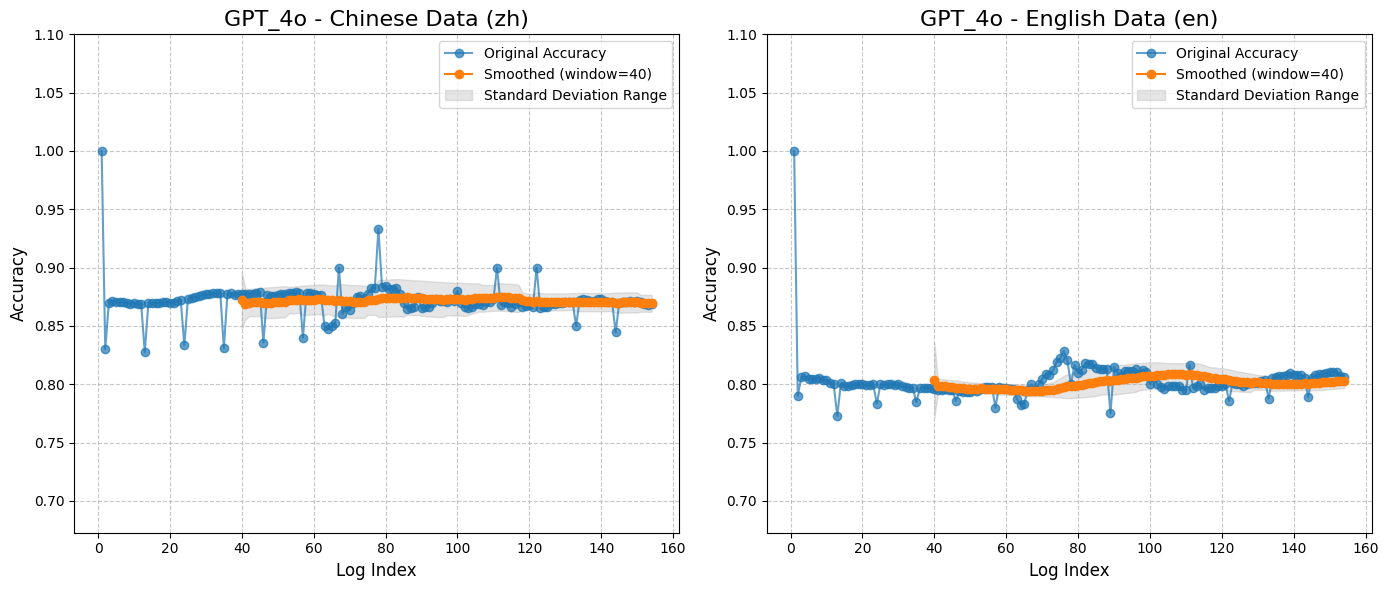

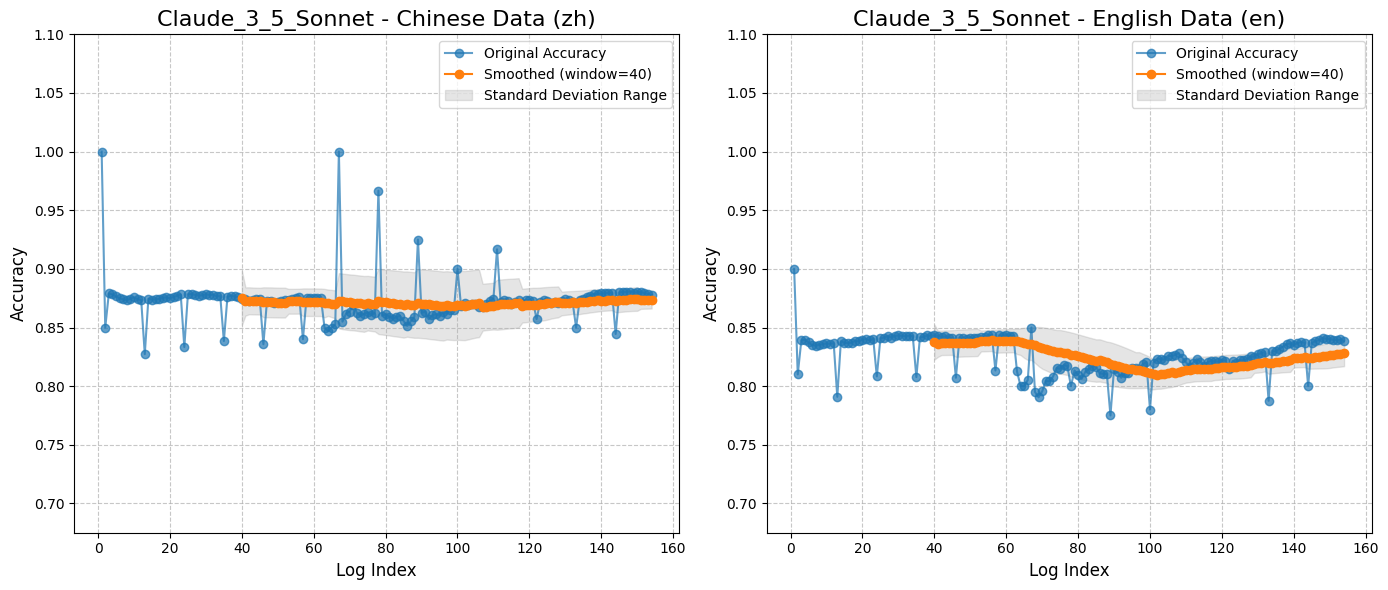

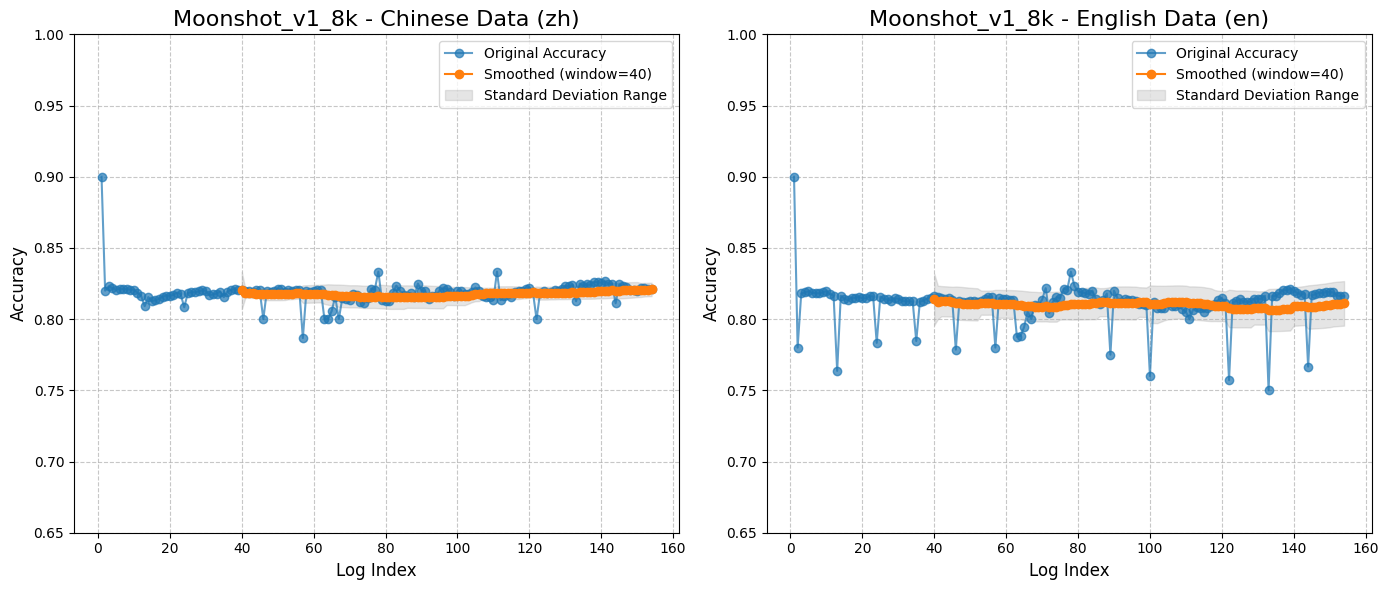

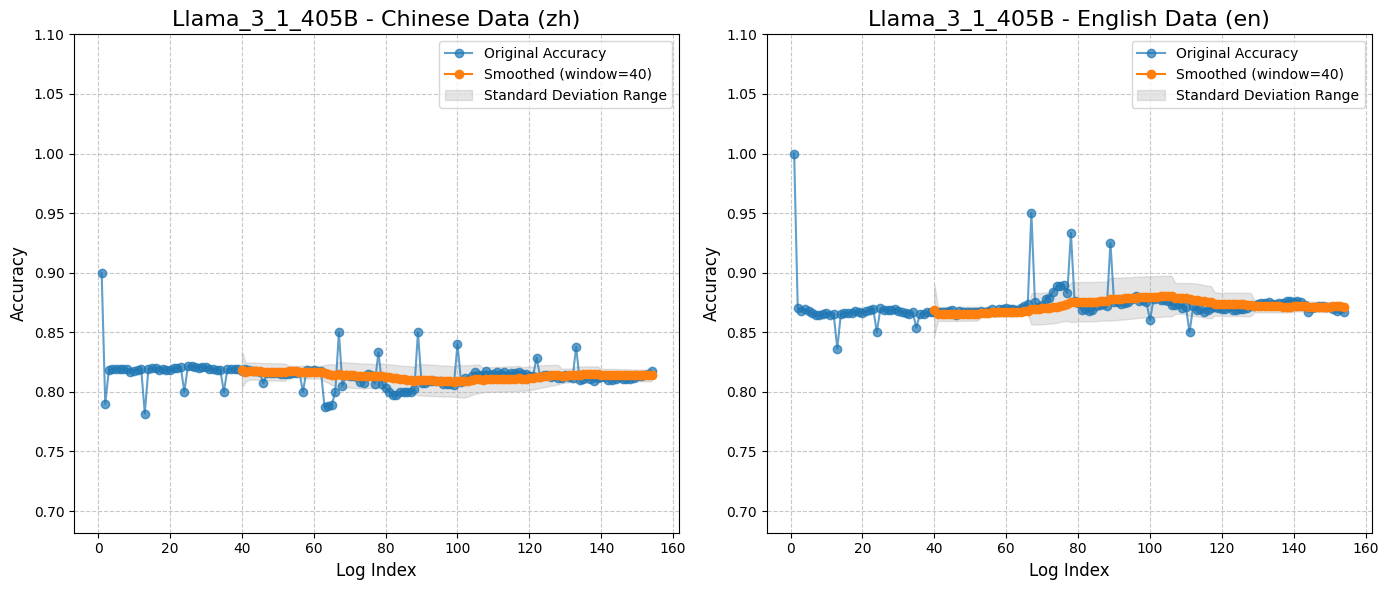

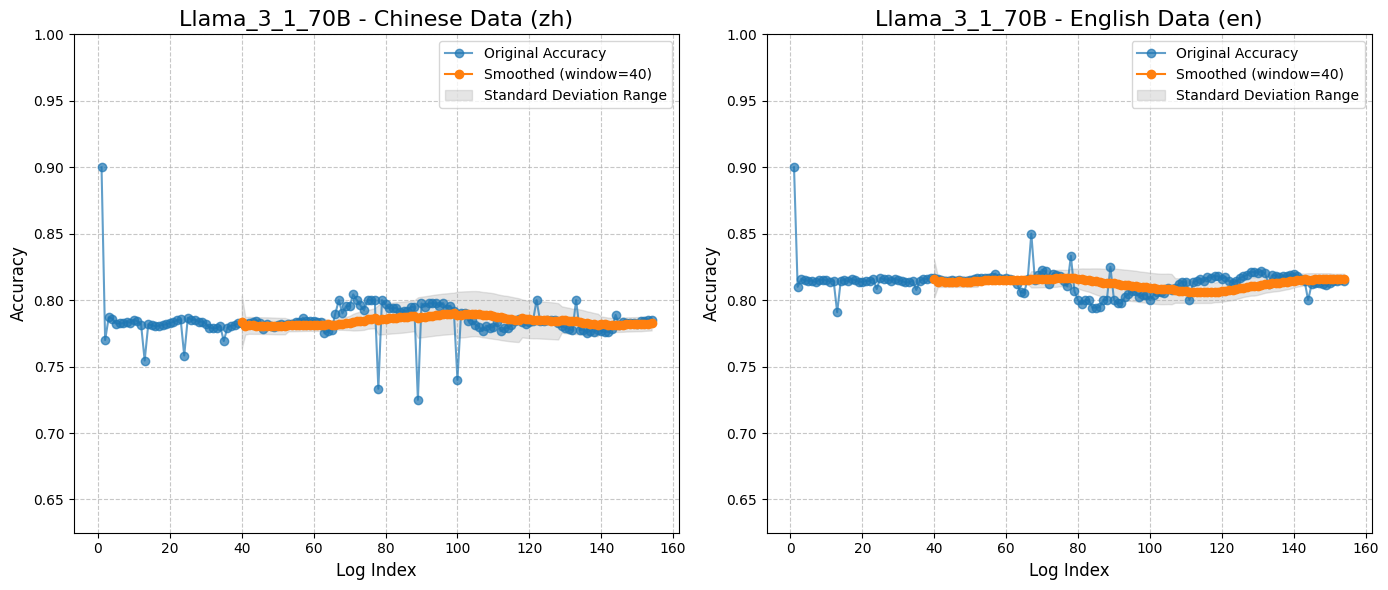

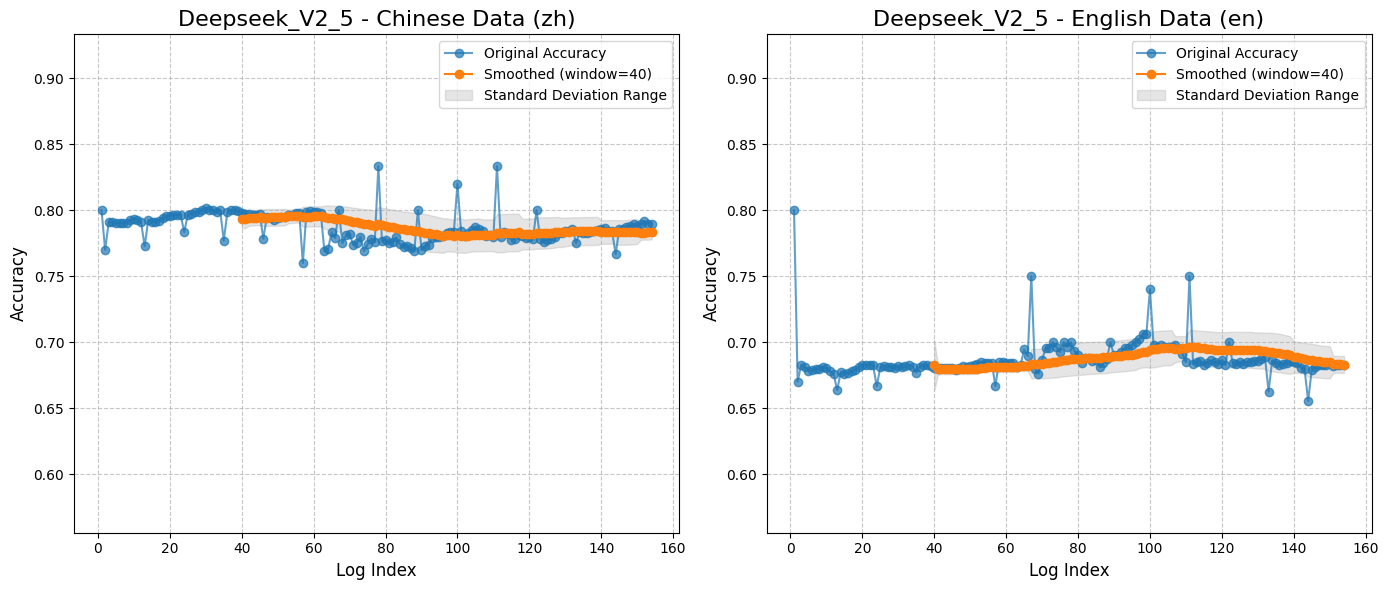

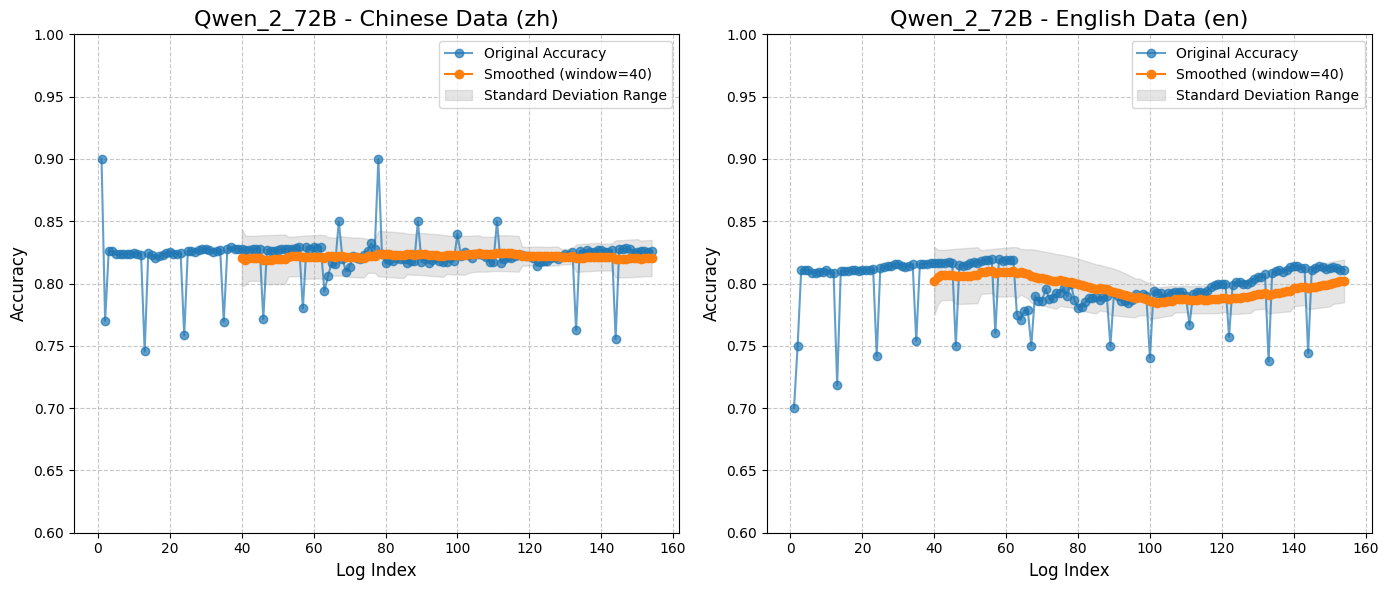

In [21]:
MODEL_NAMES = [
    'GPT_o1_Preview',
    'GPT_o1_Mini',
    'GPT_4o',
    'Claude_3_5_Sonnet',
    'Moonshot_v1_8k',
    'Llama_3_1_405B',
    'Llama_3_1_70B',
    'Deepseek_V2_5',
    'Qwen_2_72B'
]

for model_name in MODEL_NAMES:
    # Load logs for Chinese and English (0 shots)
    zh_logs_0shot = load_logs(model_name, "zh", "0")
    en_logs_0shot = load_logs(model_name, "en", "0")

    # Extract accuracies from the logs
    zh_accuracies = [log['accuracy'] for log in zh_logs_0shot]
    en_accuracies = [log['accuracy'] for log in en_logs_0shot]

    # Plot the accuracy trends for both Chinese and English data
    plot_accuracy_trend(zh_accuracies, en_accuracies, model_name, smoothing_window=40)

### Finial Results

In [9]:
def load_latest_cases(model_name, language, shot_type):
    """Load the latest cases."""
    filename_prefix = f"all_cases_{model_name}_{language}_shot{shot_type}"
    
    if language == "zh":
        log_folder = f"./logs/zh_with_{shot_type}shots"
    else:
        log_folder = f"./logs/en_with_{shot_type}shots"

    # Find all log files for the model
    log_files = glob.glob(os.path.join(log_folder, f"{filename_prefix}_*.json"))

    if not log_files:
        print(f"No log files found for model {model_name} in {log_folder}.")
        return None

    # Sort log files by the numerical part at the end of the filename
    log_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]), reverse=True)

    # Load the latest log file (the first one after sorting)
    latest_log_file = log_files[0]

    with open(latest_log_file, "r", encoding="utf-8") as f:
        data = json.load(f)
        return data.get('cases', [])

In [10]:
from eval import is_correct
from collections import defaultdict

def calculate_story_accuracy(cases, language):
    story_stats = defaultdict(lambda: {'correct': 0, 'total': 0})
    total_correct = 0
    total_samples = len(cases)

    for case in cases:
        story_title = case["story_title"]
        model_judge = case["model_judge"]
        ground_truth = case["ground_truth"]

        correct = is_correct(model_judge, ground_truth, language)
        
        story_stats[story_title]['total'] += 1
        if correct:
            story_stats[story_title]['correct'] += 1
            total_correct += 1

    story_accuracies = {}
    for story_title, stats in story_stats.items():
        accuracy = stats['correct'] / stats['total'] if stats['total'] > 0 else 0.0
        story_accuracies[story_title] = accuracy

    overall_accuracy = total_correct / total_samples if total_samples > 0 else 0.0
    average_story_accuracy = sum(story_accuracies.values()) / len(story_accuracies) if story_accuracies else 0.0

    return story_accuracies, overall_accuracy, average_story_accuracy

In [11]:
def visualize_accuracy_comparison(model_name, zh_story_accuracies, zh_overall_accuracy, zh_avg_story_accuracy, 
                                  en_story_accuracies, en_overall_accuracy, en_avg_story_accuracy, zh_cases, en_cases):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

    # Create a defaultdict to count the number of cases per story for ZH and EN data
    zh_story_counts = defaultdict(int)
    for case in zh_cases:
        zh_story_counts[case['story_title']] += 1

    en_story_counts = defaultdict(int)
    for case in en_cases:
        en_story_counts[case['story_title']] += 1

    # Update stories with the format 'Story Title (count)'
    stories_zh = [f"{story} ({zh_story_counts[story]})" for story in zh_story_accuracies.keys()]
    accuracies_zh = list(zh_story_accuracies.values())
    
    stories_en = [f"{story} ({en_story_counts[story]})" for story in en_story_accuracies.keys()]
    accuracies_en = list(en_story_accuracies.values())

    # Set min and max values for y-axis limits
    min_accuracy = min(min(accuracies_zh), min(accuracies_en), zh_overall_accuracy, en_overall_accuracy, zh_avg_story_accuracy, en_avg_story_accuracy)
    max_accuracy = max(max(accuracies_zh), max(accuracies_en), zh_overall_accuracy, en_overall_accuracy, zh_avg_story_accuracy, en_avg_story_accuracy)
    y_min = max(0.4, min_accuracy - 0.05)
    y_max = 1.0

    # Plot for Chinese stories
    bars_zh = ax1.barh(stories_zh, accuracies_zh, color='skyblue', label='story accuracy')
    ax1.axvline(zh_overall_accuracy, color='indianred', linewidth=2, linestyle='--', label='Overall Accuracy', alpha=0.7)
    ax1.axvline(zh_avg_story_accuracy, color='dimgray', linewidth=2, linestyle='-.', label='Average Story Accuracy', alpha=0.7)
    
    for bar in bars_zh:
        width = bar.get_width()
        ax1.annotate(f'{width:.2f}', xy=(width, bar.get_y() + bar.get_height() / 2),
                    xytext=(5, 0), textcoords="offset points", ha='left', va='center')

    ax1.set_yticks(range(len(stories_zh)))
    ax1.set_yticklabels(stories_zh, fontproperties=font)

    ax1.set_xlabel('Accuracy', fontsize=12)
    ax1.set_ylabel('Story Title (ZH)', fontsize=12)
    ax1.set_title(f'{model_name} - Chinese Data (ZH)', fontsize=14)
    ax1.set_xlim([y_min, y_max])
    ax1.legend()

    # Plot for English stories
    bars_en = ax2.barh(stories_en, accuracies_en, color='lightgreen', label='Story Accuracy')
    ax2.axvline(en_overall_accuracy, color='indianred', linewidth=2, linestyle='--', label='Overall Accuracy', alpha=0.7)
    ax2.axvline(en_avg_story_accuracy, color='dimgray', linewidth=2, linestyle='-.', label='Average Story Accuracy', alpha=0.7)

    
    for bar in bars_en:
        width = bar.get_width()
        ax2.annotate(f'{width:.2f}', xy=(width, bar.get_y() + bar.get_height() / 2),
                    xytext=(5, 0), textcoords="offset points", ha='left', va='center')

    ax2.set_xlabel('Accuracy', fontsize=12)
    ax2.set_ylabel('Story Title (EN)', fontsize=12)
    ax2.set_title(f'{model_name} - English Data (EN)', fontsize=14)
    ax2.set_xlim([y_min, y_max])
    ax2.legend()

    ax1.set_xlim(0, max_accuracy * 1.12)
    ax2.set_xlim(0, max_accuracy * 1.12)

    plt.tight_layout()
    plt.show()

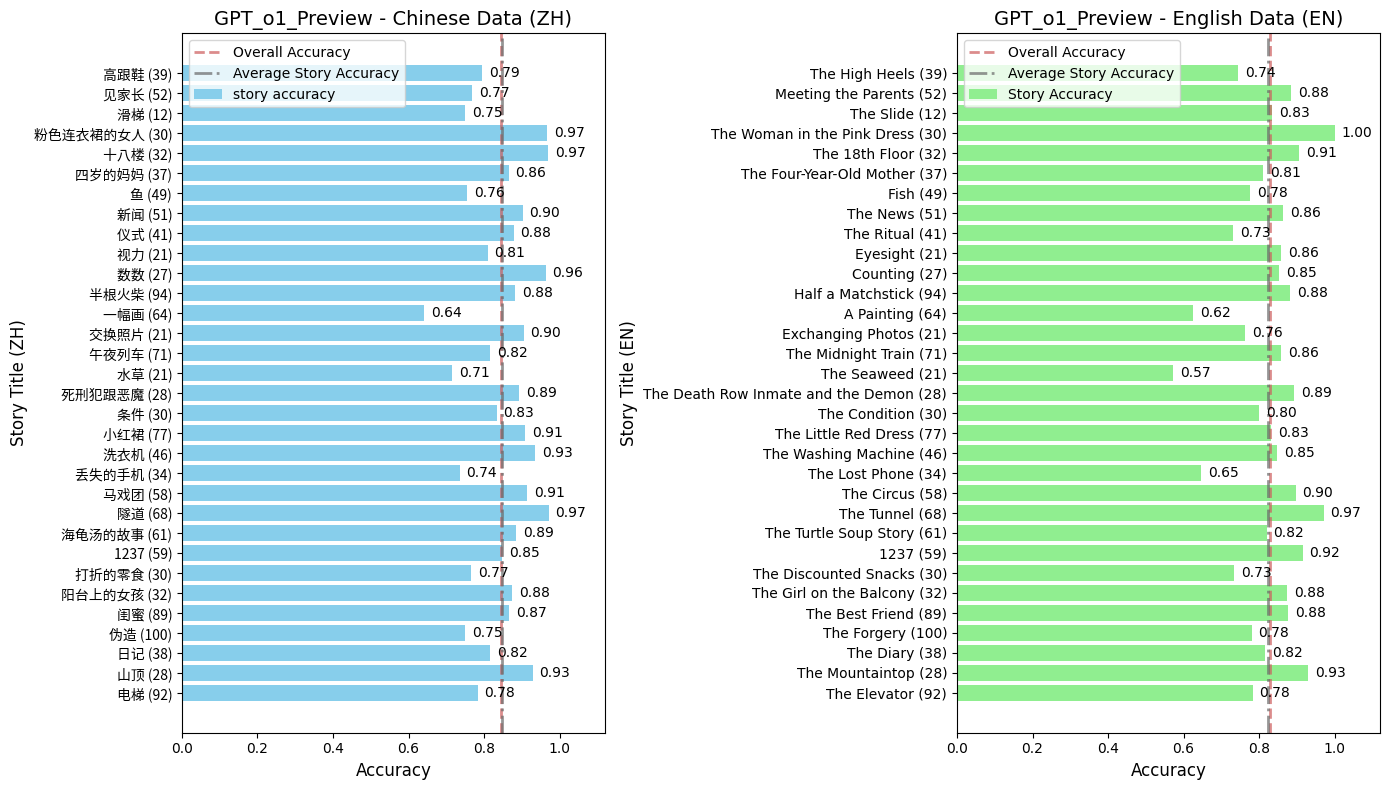

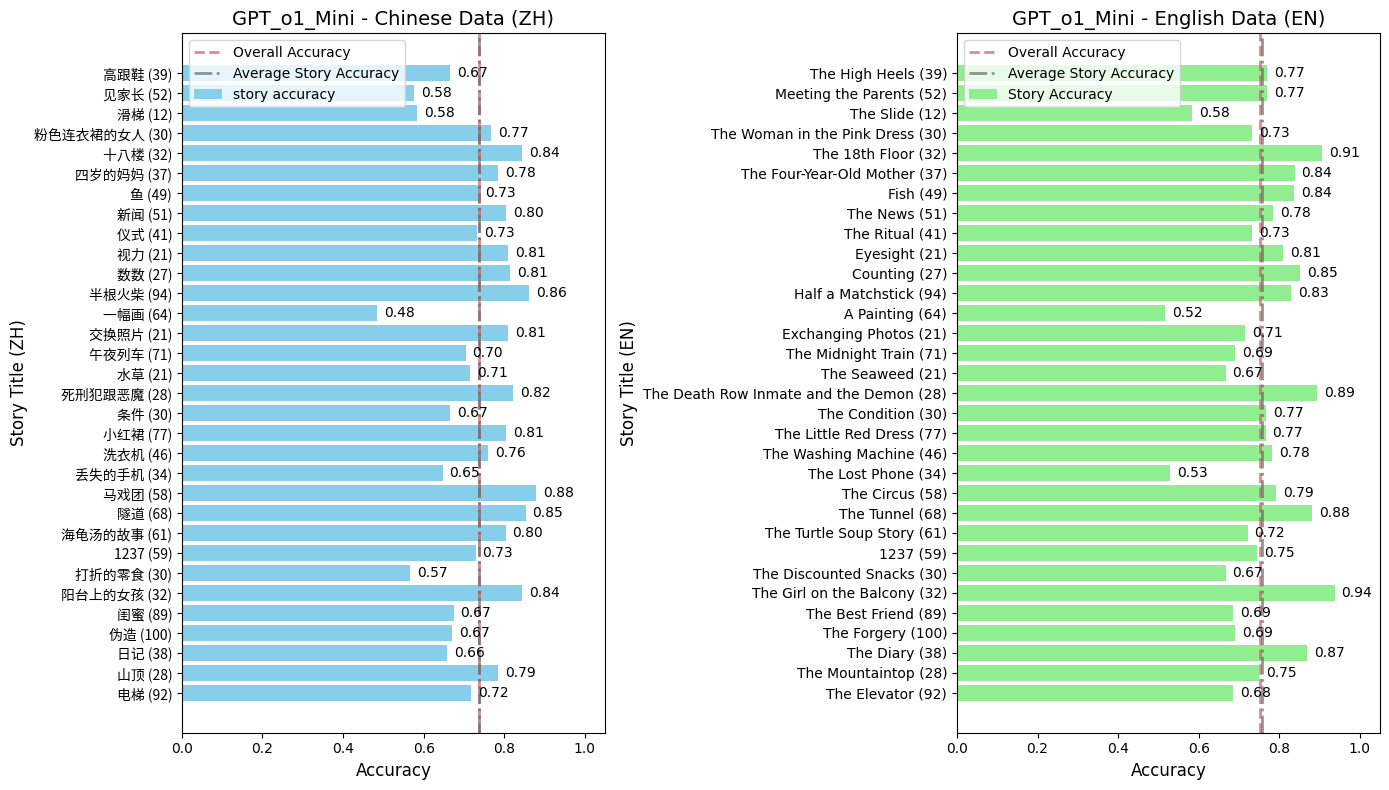

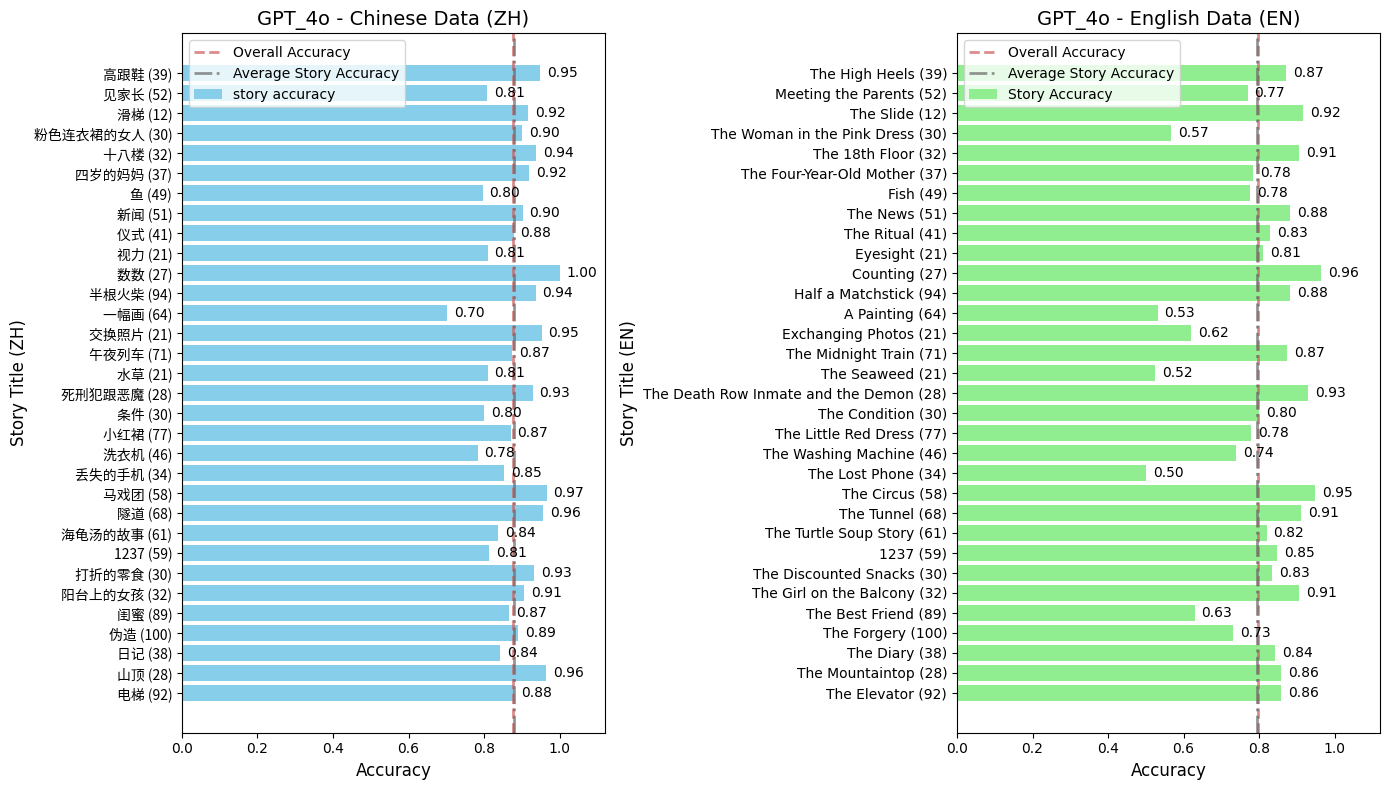

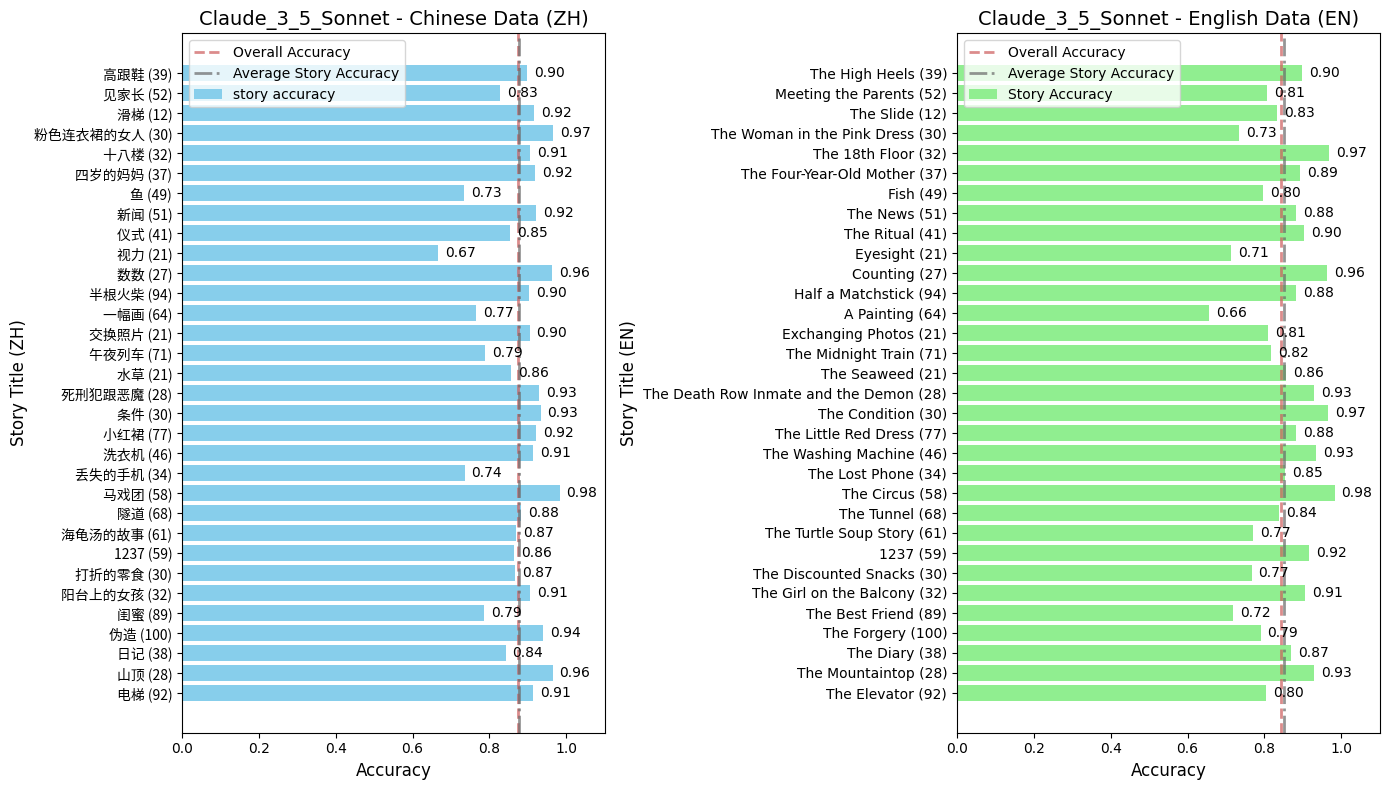

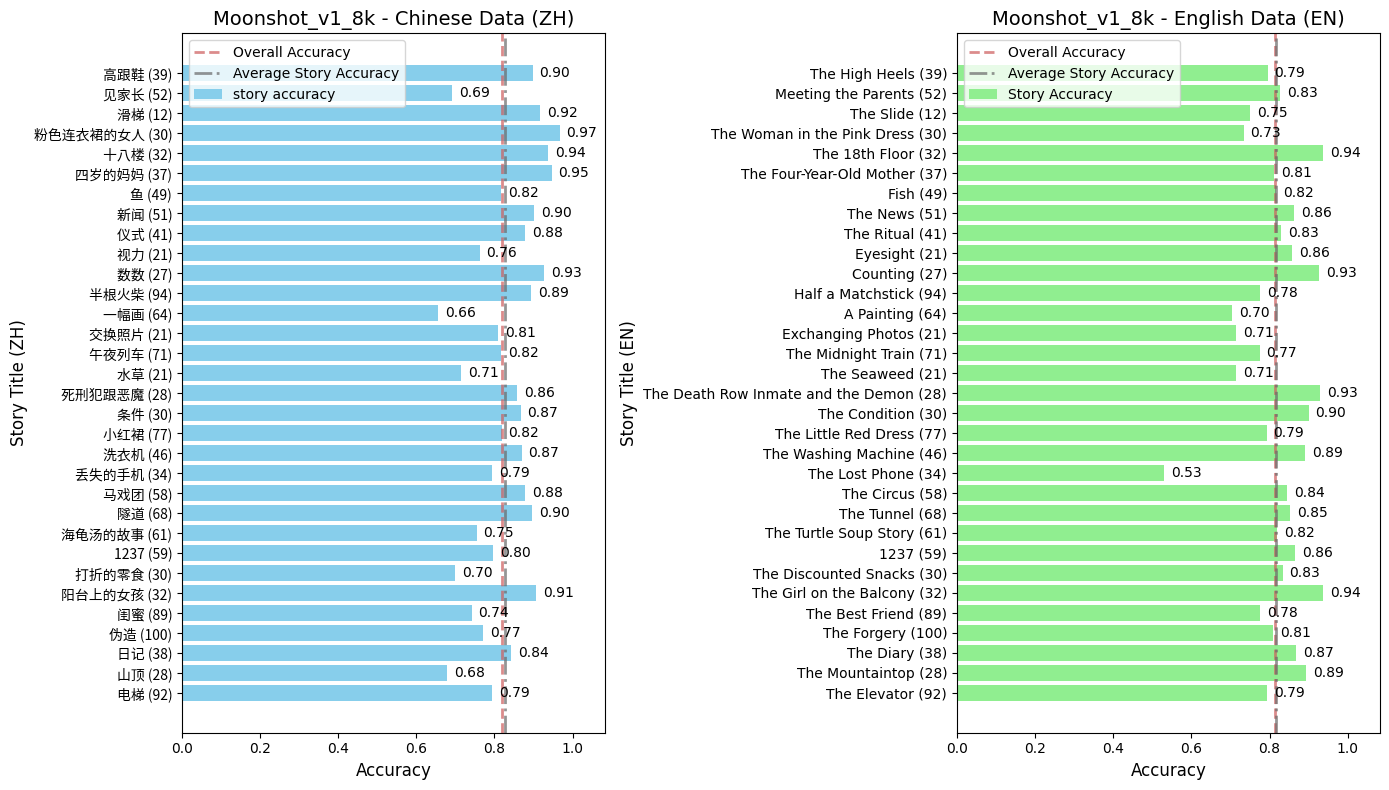

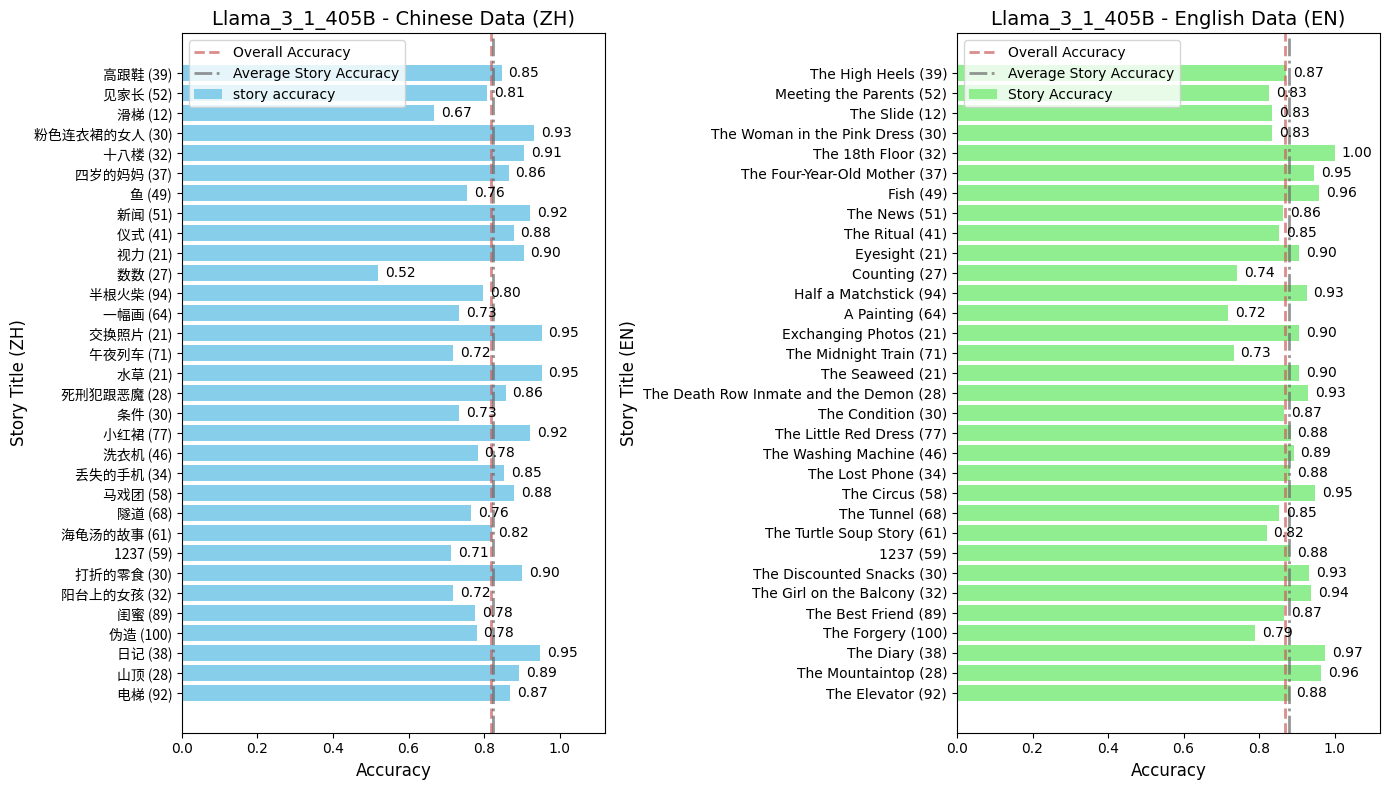

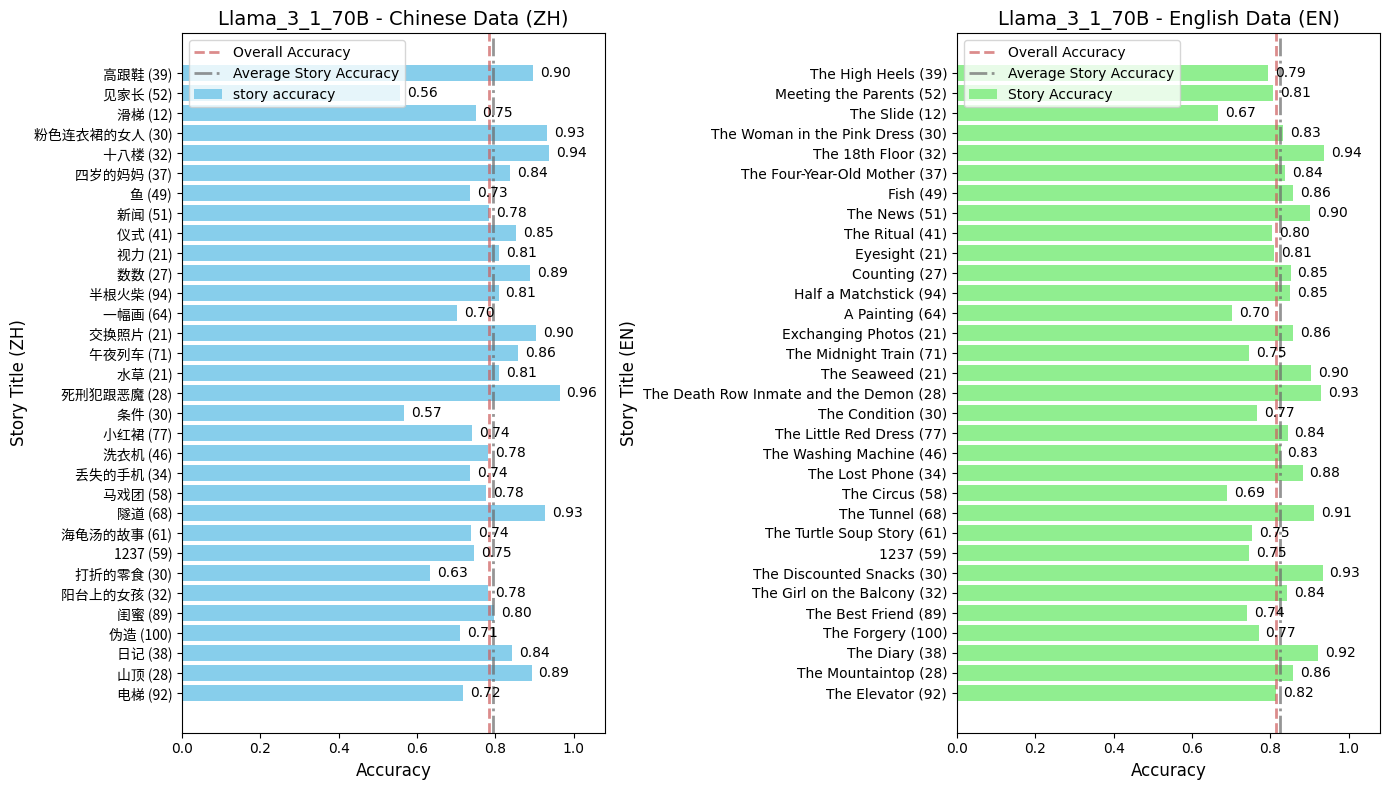

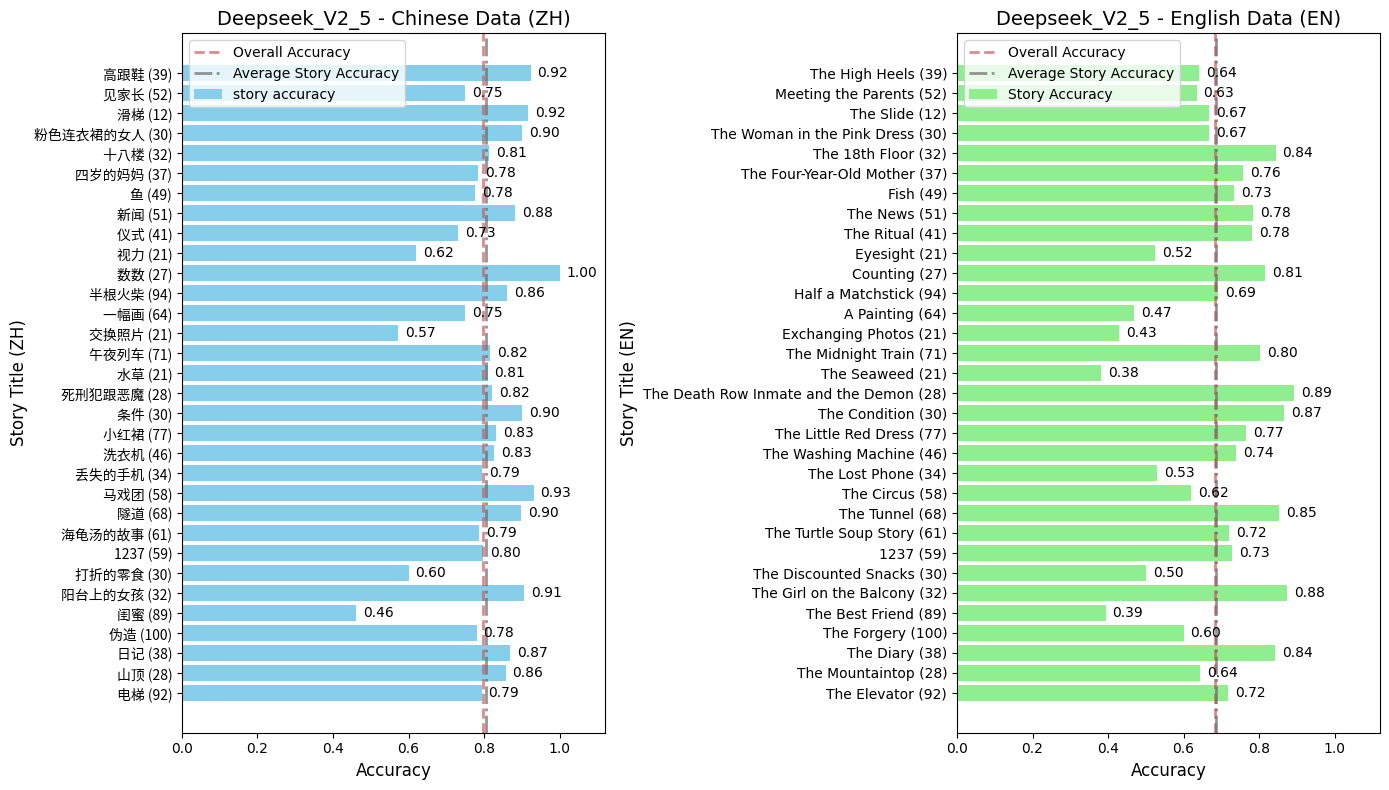

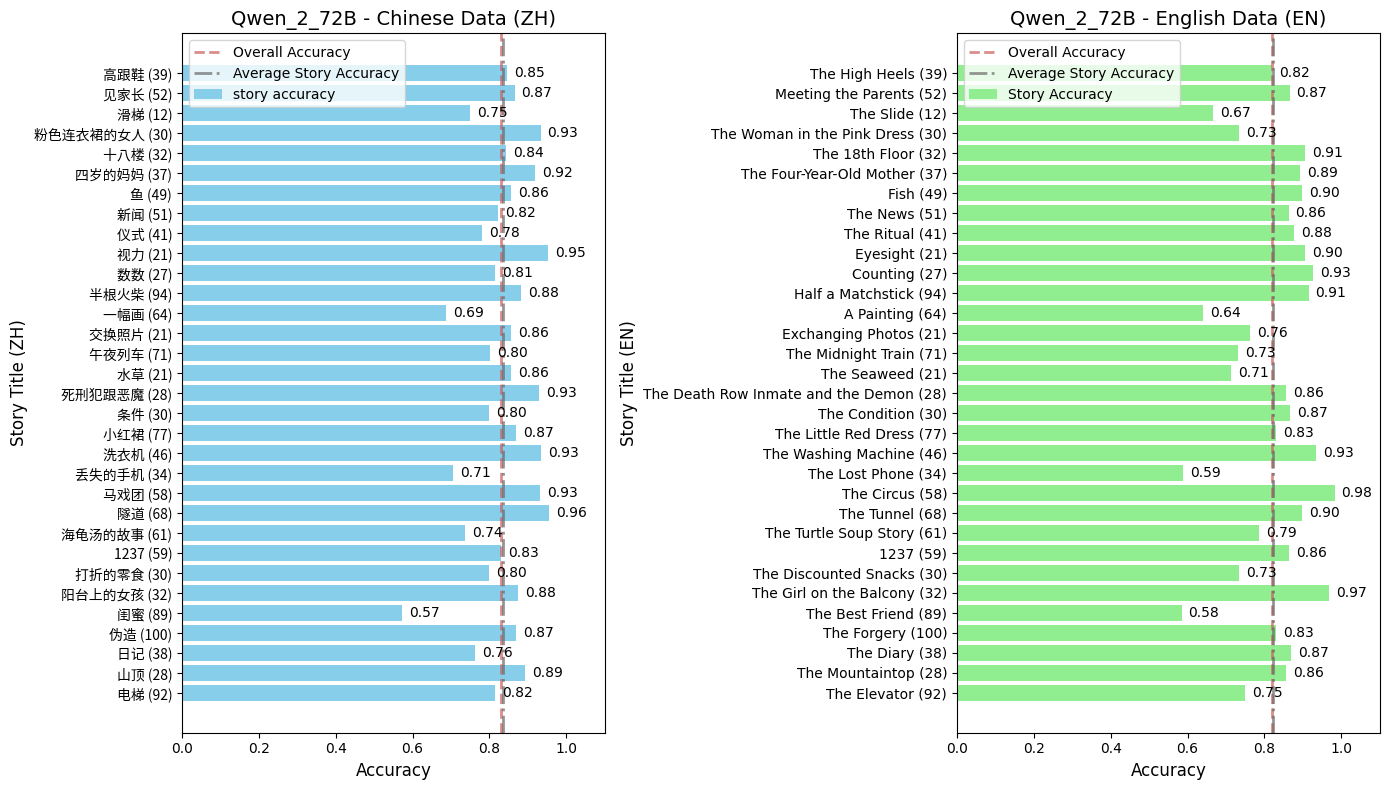

GPT_o1_Preview: ZH=0.84, EN=0.83
GPT_o1_Mini: ZH=0.74, EN=0.75
GPT_4o: ZH=0.88, EN=0.80
Claude_3_5_Sonnet: ZH=0.88, EN=0.84
Moonshot_v1_8k: ZH=0.82, EN=0.81
Llama_3_1_405B: ZH=0.82, EN=0.87
Llama_3_1_70B: ZH=0.78, EN=0.82
Deepseek_V2_5: ZH=0.80, EN=0.68
Qwen_2_72B: ZH=0.83, EN=0.82


In [12]:
MODEL_NAMES = [
    'GPT_o1_Preview',
    'GPT_o1_Mini',
    'GPT_4o',
    'Claude_3_5_Sonnet',
    'Moonshot_v1_8k',
    'Llama_3_1_405B',
    'Llama_3_1_70B',
    'Deepseek_V2_5',
    'Qwen_2_72B'
]
zh_overall_acc = {}
en_overall_acc = {}
for model_name in MODEL_NAMES:
    zh_cases = load_latest_cases(model_name, "zh", "0")
    en_cases = load_latest_cases(model_name, "en", "0")

    zh_story_accuracies, zh_overall_accuracy, zh_avg_story_accuracy = calculate_story_accuracy(zh_cases, "zh")
    en_story_accuracies, en_overall_accuracy, en_avg_story_accuracy = calculate_story_accuracy(en_cases, "en")
    visualize_accuracy_comparison(model_name, zh_story_accuracies, zh_overall_accuracy, zh_avg_story_accuracy,
                                    en_story_accuracies, en_overall_accuracy, en_avg_story_accuracy,
                                    zh_cases, en_cases)

    zh_overall_acc[model_name] = zh_overall_accuracy
    en_overall_acc[model_name] = en_overall_accuracy

for model_name in MODEL_NAMES:
    print(f"{model_name}: ZH={zh_overall_acc[model_name]:.2f}, EN={en_overall_acc[model_name]:.2f}")

In [13]:
def visualize_accuracy_difference(model_name, zh_story_accuracies, en_story_accuracies):
    stories_en = list(en_story_accuracies.keys())
    accuracies_zh = list(zh_story_accuracies.values())
    accuracies_en = list(en_story_accuracies.values())
    
    fig, ax = plt.subplots(figsize=(8, 8))

    ax.scatter(accuracies_zh, accuracies_en, color='skyblue', label='Stories', s=60)
    ax.plot([0.65, 1], [0.65, 1], linestyle='--', color='red', label='ZH = EN')

    texts = []
    for i, story in enumerate(stories_en):
        texts.append(ax.annotate(story, (accuracies_zh[i], accuracies_en[i]), fontsize=6))
    
    adjust_text(texts, only_move={'points':'xy', 'texts':'xy'}, autoalign='xy', expand_points=(1.2, 1.2))
    
    ax.set_xlim([0.65, 1.03])
    ax.set_ylim([0.65, 1.03])
    ax.set_xticks([0.7, 0.8, 0.9, 1])
    ax.set_yticks([0.7, 0.8, 0.9, 1])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_xlabel('ZH Accuracy', fontsize=12)
    ax.set_ylabel('EN Accuracy', fontsize=12)

    ax.set_title(f'{model_name} - Chinese vs. English Dataset', fontsize=14)
    ax.legend()

    plt.tight_layout()
    plt.show()

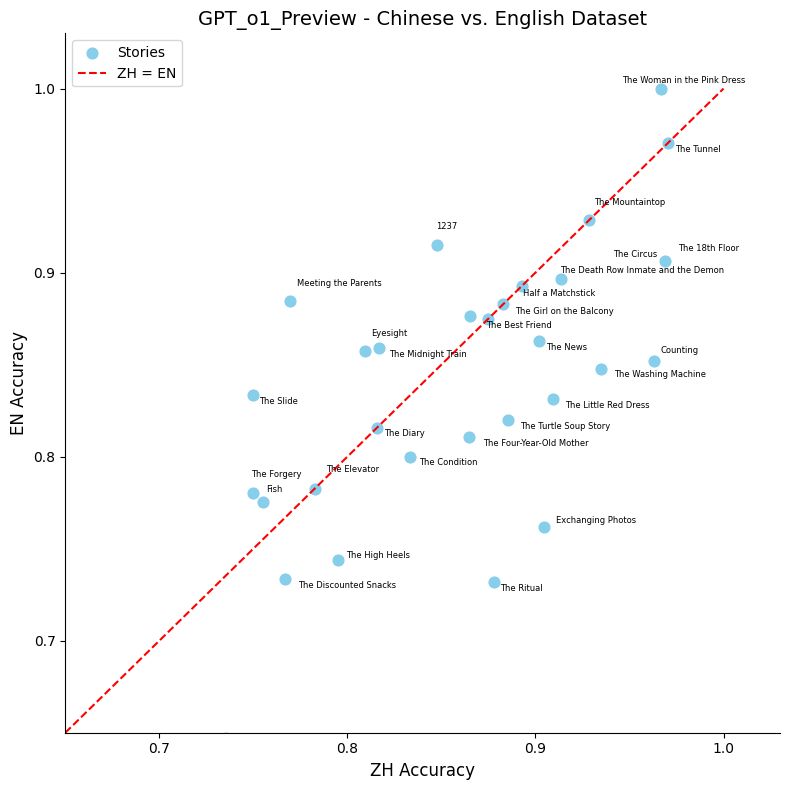

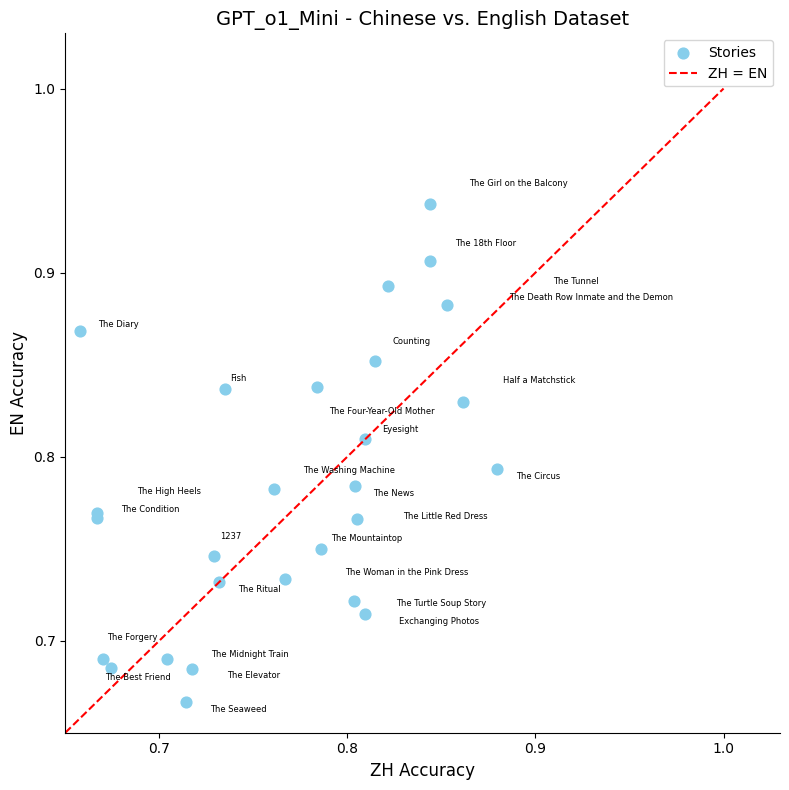

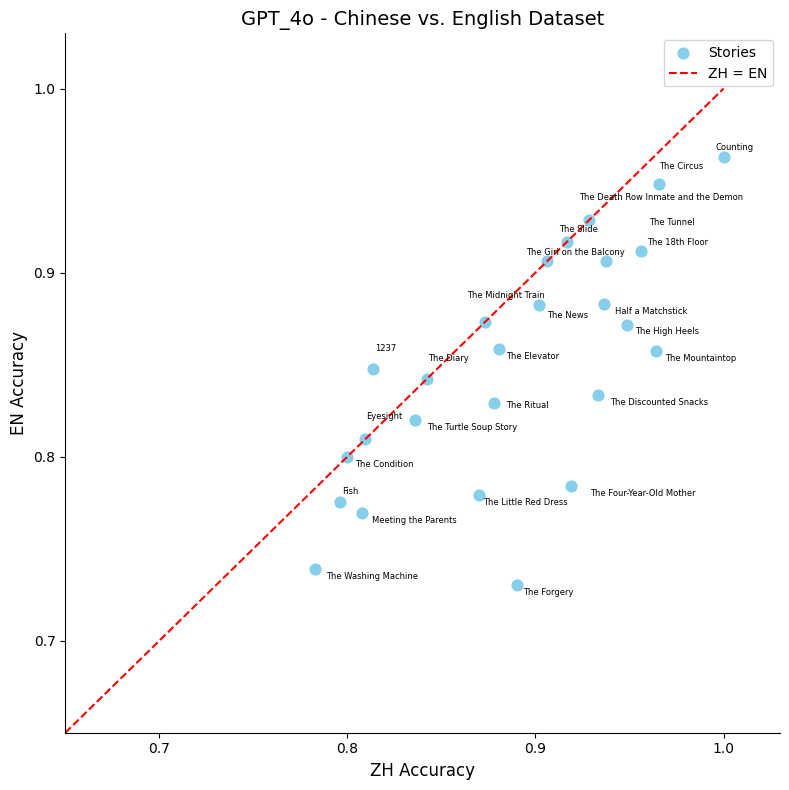

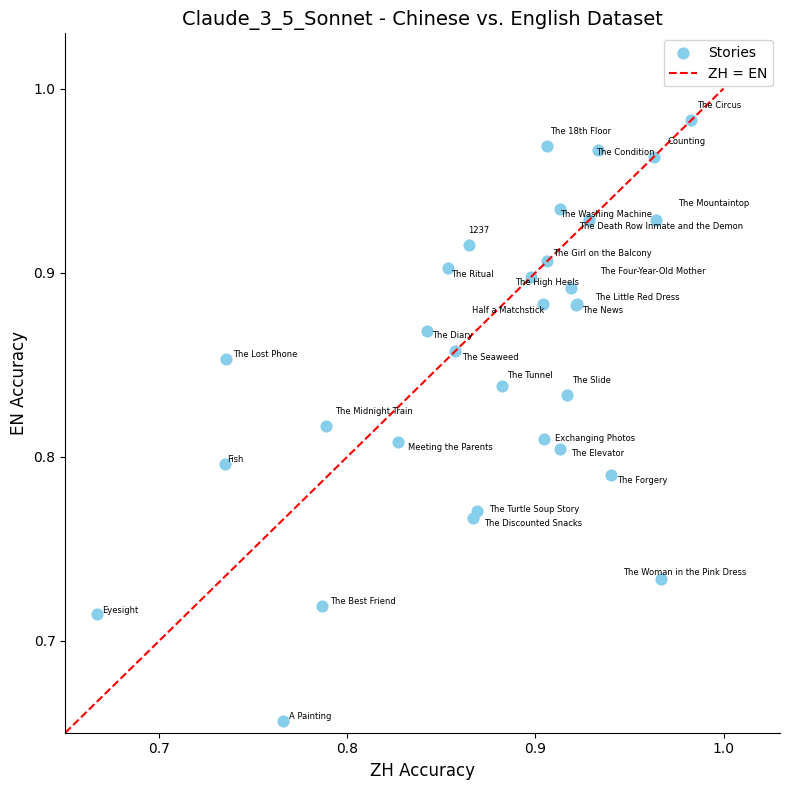

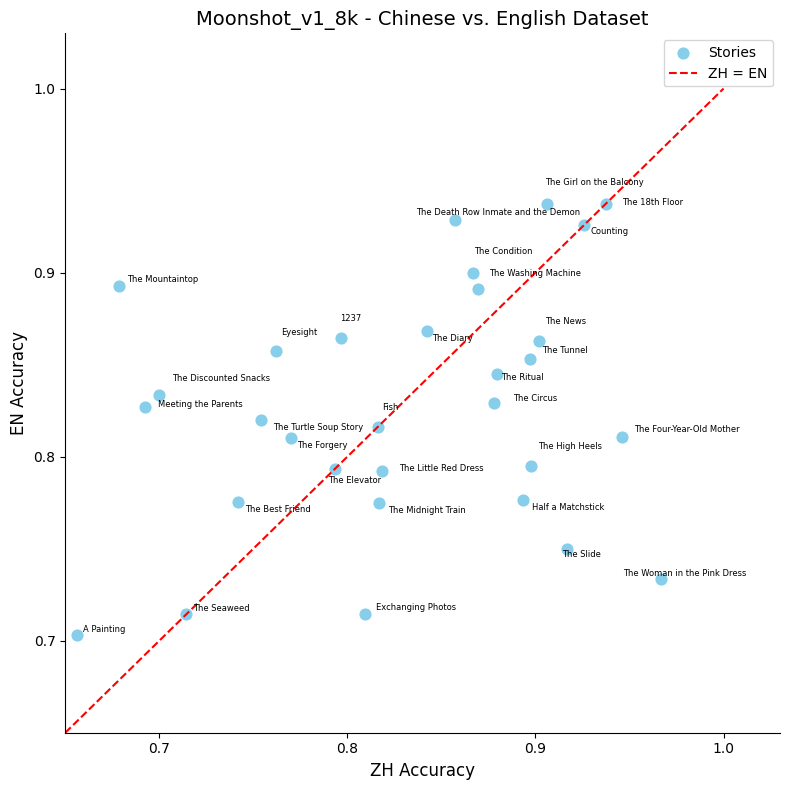

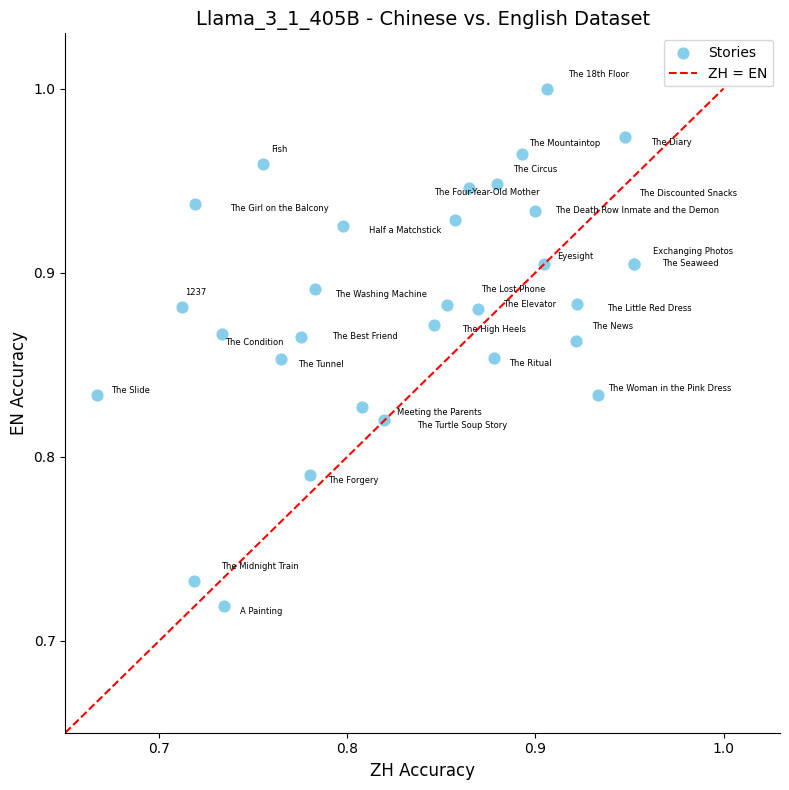

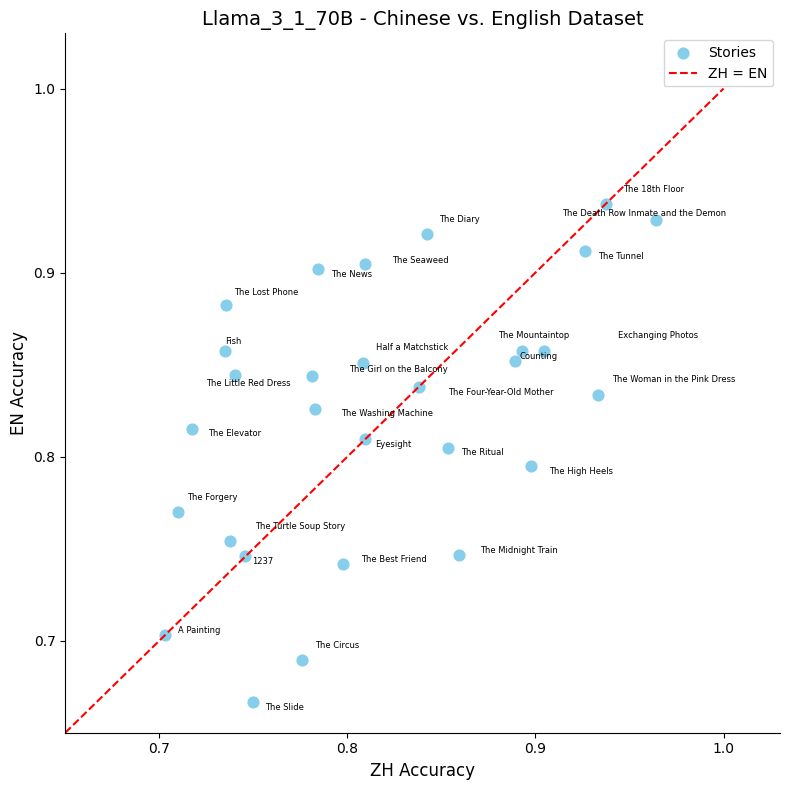

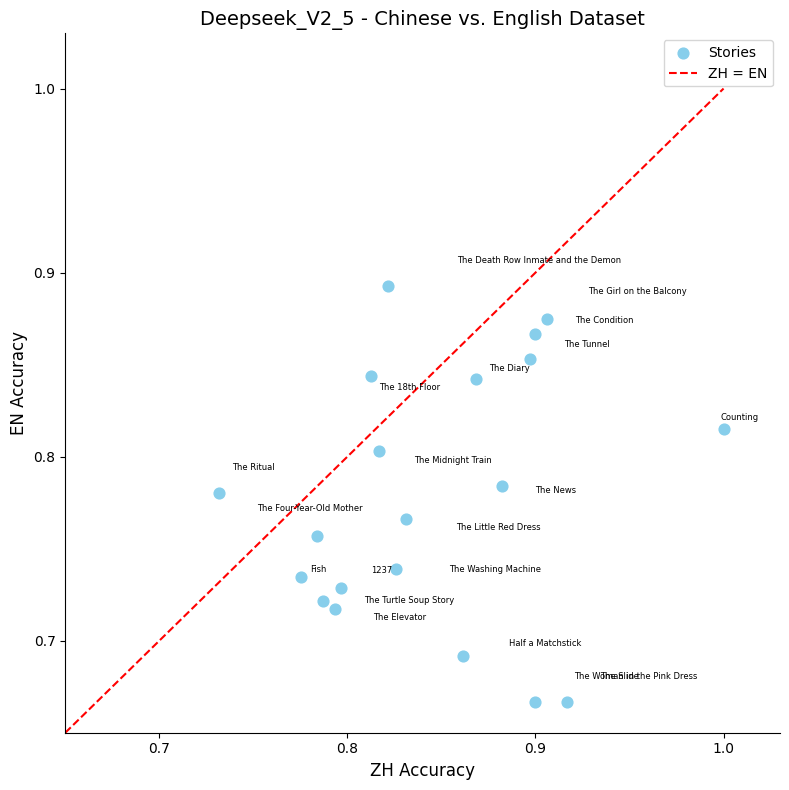

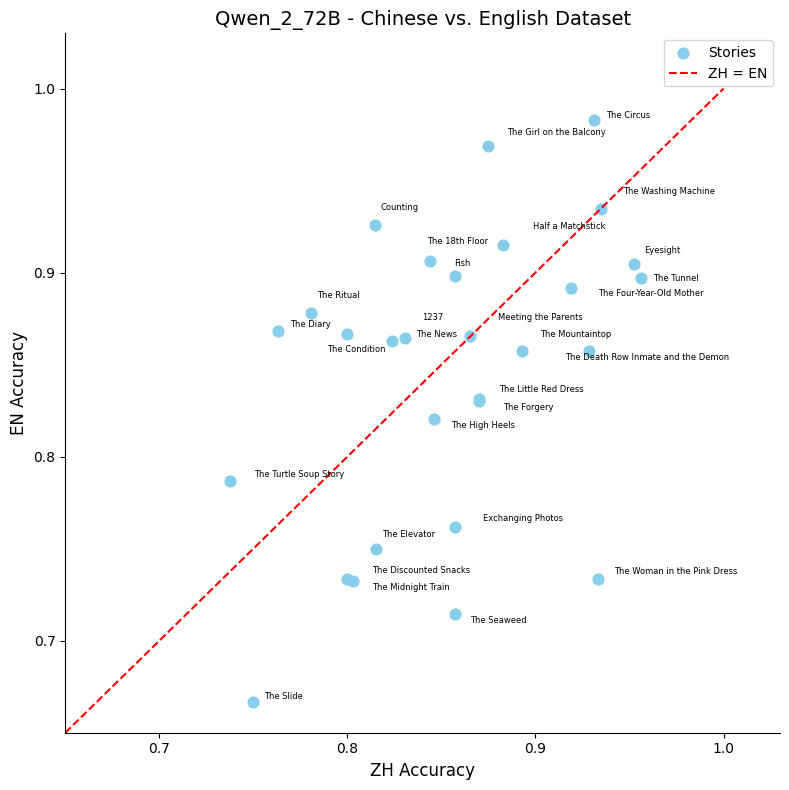

In [14]:
MODEL_NAMES = [
    'GPT_o1_Preview',
    'GPT_o1_Mini',
    'GPT_4o',
    'Claude_3_5_Sonnet',
    'Moonshot_v1_8k',
    'Llama_3_1_405B',
    'Llama_3_1_70B',
    'Deepseek_V2_5',
    'Qwen_2_72B'
]

for model_name in MODEL_NAMES:
    zh_cases = load_latest_cases(model_name, "zh", "0")
    en_cases = load_latest_cases(model_name, "en", "0")

    zh_story_accuracies, zh_overall_accuracy, zh_avg_story_accuracy = calculate_story_accuracy(zh_cases, "zh")
    en_story_accuracies, en_overall_accuracy, en_avg_story_accuracy = calculate_story_accuracy(en_cases, "en")
    visualize_accuracy_difference(model_name, zh_story_accuracies, en_story_accuracies)


In [15]:
def read_stats():
    stats_dir = "./stats"
    files = [f for f in os.listdir(stats_dir) if f.startswith("stats_") and f.endswith(".csv")]
    latest_file = max(files, key=lambda f: datetime.strptime(f.split('_')[1], "%Y%m%d"))
    stats_file = os.path.join(stats_dir, latest_file)
    stats = pd.read_csv(stats_file)
    
    return stats

In [16]:
def plot_accuracy_bubble(stats):
    # Split by language
    stats_en = stats[stats['Language'] == 'en']
    stats_zh = stats[stats['Language'] == 'zh']

    # Create a figure with two subplots for English and Chinese
    plt.figure(figsize=(14, 6))

    # Generate unique colors for models (assign the same color for the same model in both datasets)
    unique_models = sorted(set(stats['Model']))  # Get unique models across both datasets
    tableau_colors = list(mcolors.TABLEAU_COLORS.values())  # Convert dict values to a list
    color_map = {model: tableau_colors[i % len(tableau_colors)] for i, model in enumerate(unique_models)}

    # Chinese Dataset
    plt.subplot(1, 2, 1)
    texts_zh = []
    for i, model in enumerate(stats_zh['Model']):
        color = color_map[model]  # Use consistent color based on the model
        plt.scatter(stats_zh['Accuracy'].iloc[i], stats_zh['Avg Story Accuracy'].iloc[i], 
                    s=80, alpha=0.7, c=[color])  # Adjust alpha for clarity
        texts_zh.append(plt.text(stats_zh['Accuracy'].iloc[i], stats_zh['Avg Story Accuracy'].iloc[i], 
                                 model, fontsize=7, ha='right', color=color))  # Use same color for text
    adjust_text(texts_zh, only_move={'points': 'xy', 'texts': 'xy'}, autoalign='xy', expand_points=(1.2, 1.2))  # Adjust text positions
    plt.title('Chinese Dataset', fontsize=12)
    plt.xlabel('Accuracy', fontsize=10)
    plt.ylabel('Avg Story Accuracy', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)

    # English Dataset
    plt.subplot(1, 2, 2)
    texts_en = []
    for i, model in enumerate(stats_en['Model']):
        color = color_map[model]  # Use consistent color based on the model
        plt.scatter(stats_en['Accuracy'].iloc[i], stats_en['Avg Story Accuracy'].iloc[i], 
                    s=80, alpha=0.7, c=[color])  # Adjust alpha for clarity
        texts_en.append(plt.text(stats_en['Accuracy'].iloc[i], stats_en['Avg Story Accuracy'].iloc[i], 
                                 model, fontsize=7, ha='left', color=color))  # Use same color for text
    adjust_text(texts_en, only_move={'points': 'xy', 'texts': 'xy'}, autoalign='xy', expand_points=(1.2, 1.2))  # Adjust text positions
    plt.title('English Dataset', fontsize=12)
    plt.xlabel('Accuracy', fontsize=10)
    plt.ylabel('Avg Story Accuracy', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

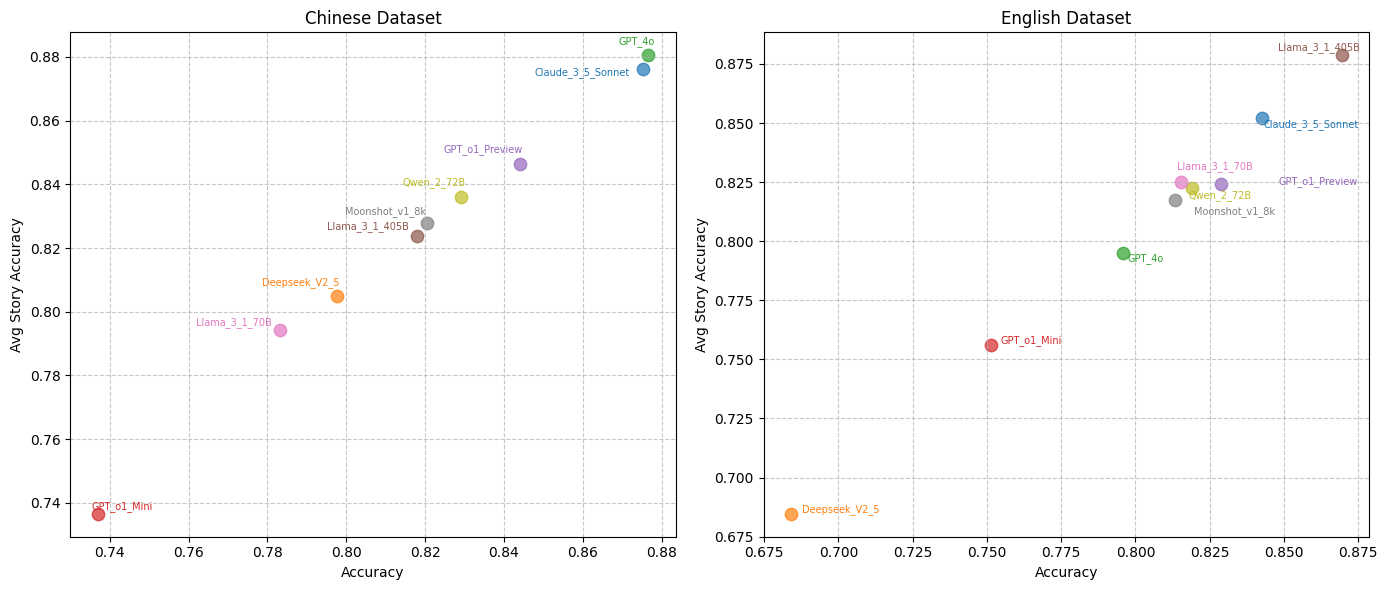

In [17]:
stats = read_stats()
plot_accuracy_bubble(stats)